In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from transformers import AutoTokenizer, AutoModel

In [2]:
# Load the the dataset, including molecular descriptors
df = pd.read_csv("data/hDHFR_pIC50_data.csv")
print(f'Number of examples is: {len(df)}')
df.columns

Number of examples is: 560


Index(['XLogP', 'LipinskiFailures', 'nRotB', 'MLogP', 'nAtomLAC', 'nAtomP',
       'nAtomLC', 'nBase', 'naAromAtom', 'ALogP', 'ALogp2', 'nSmallRings',
       'nRingBlocks', 'nAromBlocks', 'nRings6', 'WPATH', 'WTPT.2', 'WTPT.4',
       'WTPT.5', 'MDEC.11', 'MDEC.12', 'MDEC.13', 'MDEC.22', 'MDEC.23',
       'MDEC.33', 'MDEO.11', 'MDEO.22', 'MDEN.11', 'MDEN.12', 'MDEN.13',
       'MDEN.22', 'khs.ssCH2', 'khs.dsCH', 'khs.aaCH', 'khs.sssCH', 'khs.tsC',
       'khs.dssC', 'khs.aasC', 'khs.aaaC', 'khs.ssssC', 'khs.sNH2', 'khs.ssNH',
       'khs.aaNH', 'khs.aaN', 'khs.sssN', 'khs.aasN', 'khs.sOH', 'khs.ssO',
       'khs.aaO', 'khs.ssS', 'khs.aaS', 'khs.sCl', 'HybRatio', 'FMF', 'ECCEN',
       'SP.7', 'VP.7', 'SPC.6', 'VPC.6', 'SC.3', 'SC.5', 'VC.3', 'VC.5',
       'SCH.5', 'SCH.6', 'SCH.7', 'VCH.5', 'VCH.6', 'C1SP2', 'C2SP2', 'C3SP2',
       'C1SP3', 'C2SP3', 'C3SP3', 'ATSp5', 'ATSm1', 'tpsaEfficiency.1',
       'nHBDon', 'bpol', 'topoShape.1', 'pIC50', 'CANONICAL_SMILES'],
      dtype='object

In [3]:
# Specify the column names of the descriptors
descriptors = ['XLogP', 'LipinskiFailures', 'nRotB', 'MLogP', 'nAtomLAC', 'nAtomP',
               'nAtomLC', 'nBase', 'naAromAtom', 'ALogP', 'ALogp2', 'nSmallRings',
               'nRingBlocks', 'nAromBlocks', 'nRings6', 'WPATH', 'WTPT.2', 'WTPT.4',
               'WTPT.5', 'MDEC.11', 'MDEC.12', 'MDEC.13', 'MDEC.22', 'MDEC.23',
               'MDEC.33', 'MDEO.11', 'MDEO.22', 'MDEN.11', 'MDEN.12', 'MDEN.13',
               'MDEN.22', 'khs.ssCH2', 'khs.dsCH', 'khs.aaCH', 'khs.sssCH', 'khs.tsC',
               'khs.dssC', 'khs.aasC', 'khs.aaaC', 'khs.ssssC', 'khs.sNH2', 'khs.ssNH',
               'khs.aaNH', 'khs.aaN', 'khs.sssN', 'khs.aasN', 'khs.sOH', 'khs.ssO',
               'khs.aaO', 'khs.ssS', 'khs.aaS', 'khs.sCl', 'HybRatio', 'FMF', 'ECCEN',
               'SP.7', 'VP.7', 'SPC.6', 'VPC.6', 'SC.3', 'SC.5', 'VC.3', 'VC.5',
               'SCH.5', 'SCH.6', 'SCH.7', 'VCH.5', 'VCH.6', 'C1SP2', 'C2SP2', 'C3SP2',
               'C1SP3', 'C2SP3', 'C3SP3', 'ATSp5', 'ATSm1', 'tpsaEfficiency.1',
               'nHBDon', 'bpol', 'topoShape.1']

In [4]:
# Load pre-trained model and tokenizer
model_name = 'DeepChem/ChemBERTa-77M-MLM'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Tokenize your input data
input_texts = list(df["CANONICAL_SMILES"])
input_ids = tokenizer(input_texts, padding=True, truncation=True, return_tensors="pt")

# Pass tokenized input through the model to obtain embeddings
with torch.no_grad():
    outputs = model(**input_ids)
    embeddings = outputs.last_hidden_state

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# (number_of_examples, max_length, hidden_dimentions)
embeddings.shape

torch.Size([560, 166, 384])

In [6]:
# Flatten embeddings by pooling across the sequence dimension
pooled_embeddings = torch.mean(embeddings, dim=1)  # use mean; other pooling methods can be used
pooled_embeddings.shape

torch.Size([560, 384])

In [7]:
# Concatenate the embeddings with the dataset
column_names = ['x' + str(i) for i in range(pooled_embeddings.shape[1])]
pooled_embeddings_df = pd.DataFrame(data=pooled_embeddings, columns=column_names)
data = pd.concat([df, pooled_embeddings_df], axis=1)

In [8]:
# Split the dataset into train, validation, and test sets
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=21)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=21)
print(f"There are {len(train_df)} molecules in Train df.")
print(f"There are {len(val_df)} molecules in Val df.")
print(f"There are {len(test_df)} molecules in Test df.")

There are 448 molecules in Train df.
There are 56 molecules in Val df.
There are 56 molecules in Test df.


In [9]:
# Create an XGBoost regressor with the specified parameters; TODO: hyperparameter-tuning
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.9,
    learning_rate=0.1,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    random_state=42  # Set a random seed for reproducibility
)

# Fit the model to the data
xgb_model.fit(train_df[column_names + descriptors], train_df["pIC50"])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:
# Calculate and print Mean Squared Error (MSE) and Spearman Correlation
def get_metrics(X_, y_, model, option='Train'):
    # Get training predictions
    y_pred = xgb_model.predict(X_)
    
    # Calculate Mean Squared Error
    mse = np.round(mean_squared_error(y_, y_pred), 4)
    print(f"{option} Mean Squared Error:", mse)

    # Calculate Spearman Correlation
    spearman_corr, _ = np.round(spearmanr(y_, y_pred), 4)
    print(f"{option} Spearman Correlation:", spearman_corr)

# Get metrics for train, validation, and test sets
get_metrics(train_df[column_names + descriptors], train_df["pIC50"], xgb_model, option='Train')
get_metrics(val_df[column_names + descriptors], val_df["pIC50"], xgb_model, option='Val')
get_metrics(test_df[column_names + descriptors], test_df["pIC50"], xgb_model, option='Val')

Train Mean Squared Error: 0.0011
Train Spearman Correlation: 0.9995
Val Mean Squared Error: 0.5704
Val Spearman Correlation: 0.7104
Val Mean Squared Error: 0.61
Val Spearman Correlation: 0.7555


In [11]:
# Calculate the predictions for the test set
pred = xgb_model.predict(test_df[column_names + descriptors])
actual = test_df['pIC50']

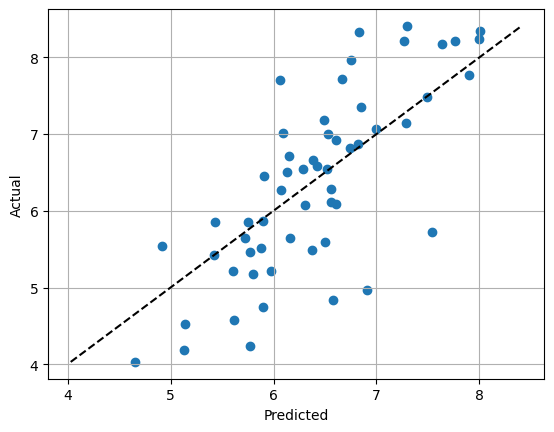

In [12]:
# Scatterplot of predicted vs. actual values 
plt.scatter(pred, actual)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid();